In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt


In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return preprocess_input(array)


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Construct the full name of the last convolutional layer within the model
    # grad_model = keras.models.Model(
    #     model.inputs, [model.get_layer('efficientnetv2-b0').get_layer(last_conv_layer_name).output, model.output]
    # )
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [1]:
from tensorflow.keras.applications import EfficientNetV2B0

model = EfficientNetV2B0(weights="imagenet")

29403144/29403144 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
for layer in model.layers[::-1]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name, layer.output.shape)
        break


top_conv (None, 7, 7, 1280)


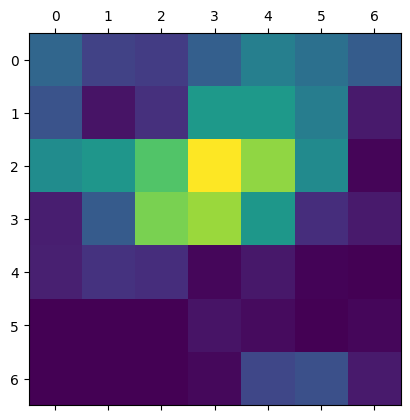

In [ ]:
# Generate class activation heatmap
last_conv_layer_name = "top_conv"
img_path = "/content/distal-subungual-onychomycosis-86_nail_fungus.jpg"
img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


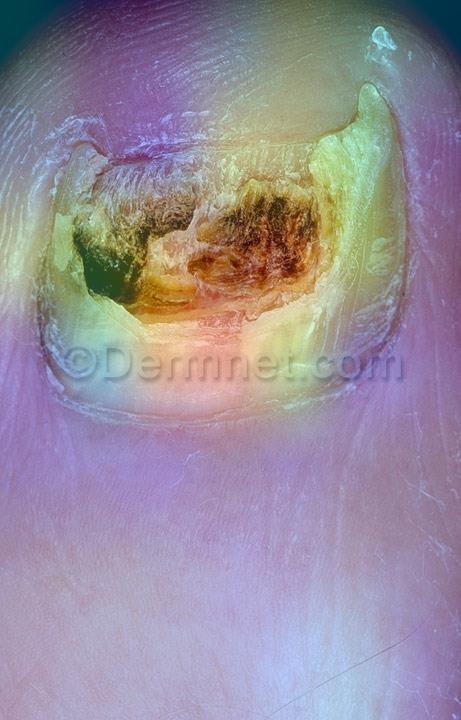

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)


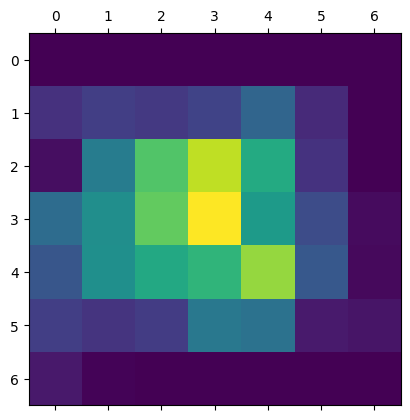

In [ ]:
second_img_path = "/content/Atypical-Pyoderma-Gangrenosum-1_vasculitis.jpg"
second_img_array = get_img_array(second_img_path, size=(224, 224))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(second_img_array, model, last_conv_layer_name)
# Display heatmap
plt.matshow(heatmap)
plt.show()


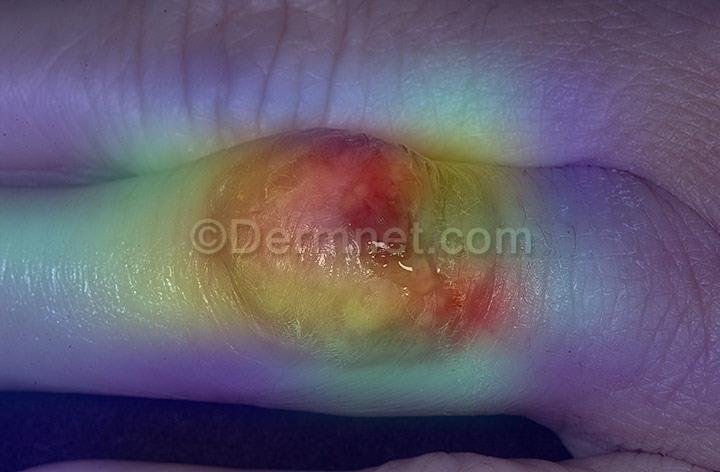

In [ ]:
save_and_display_gradcam(second_img_path, heatmap)
